100%|███████████████████████████████████████████████████████████████████████████████| 551/551 [00:03<00:00, 147.55it/s]


Training samples: 2217, Validation samples: 551

STAGE 1: Training only the top layers (all base layers frozen)
Total layers: 390
Trainable layers: 4

Training Stage 1...
Epoch 1/30
138/138 [==============================] - ETA: 0s - loss: 6.9817 - accuracy: 0.1186
New best validation accuracy: 0.1869 at epoch 1
138/138 [==============================] - 23s 110ms/step - loss: 6.9817 - accuracy: 0.1186 - val_loss: 6.2441 - val_accuracy: 0.1869
Epoch 2/30
138/138 [==============================] - ETA: 0s - loss: 5.5332 - accuracy: 0.2422
New best validation accuracy: 0.2777 at epoch 2
138/138 [==============================] - 13s 96ms/step - loss: 5.5332 - accuracy: 0.2422 - val_loss: 4.6827 - val_accuracy: 0.2777
Epoch 3/30
138/138 [==============================] - ETA: 0s - loss: 4.0203 - accuracy: 0.3403
New best validation accuracy: 0.3848 at epoch 3
138/138 [==============================] - 13s 96ms/step - loss: 4.0203 - accuracy: 0.3403 - val_loss: 3.4348 - val_accuracy: 0.38

Epoch 10/50
138/138 [==============================] - 18s 129ms/step - loss: 0.4012 - accuracy: 0.9468 - val_loss: 0.8829 - val_accuracy: 0.7895
Epoch 11/50
138/138 [==============================] - 18s 129ms/step - loss: 0.3694 - accuracy: 0.9468 - val_loss: 0.8310 - val_accuracy: 0.7985
Epoch 12/50
138/138 [==============================] - 18s 129ms/step - loss: 0.3450 - accuracy: 0.9518 - val_loss: 0.8385 - val_accuracy: 0.7949
Epoch 13/50
138/138 [==============================] - 18s 129ms/step - loss: 0.3268 - accuracy: 0.9509 - val_loss: 0.8467 - val_accuracy: 0.7858
Epoch 14/50
138/138 [==============================] - 18s 129ms/step - loss: 0.2918 - accuracy: 0.9664 - val_loss: 0.7887 - val_accuracy: 0.7985
Epoch 15/50
138/138 [==============================] - 18s 129ms/step - loss: 0.2674 - accuracy: 0.9696 - val_loss: 0.7792 - val_accuracy: 0.8167
Epoch 16/50
138/138 [==============================] - 18s 129ms/step - loss: 0.2635 - accuracy: 0.9646 - val_loss: 0.8157 -

138/138 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9891
New best validation accuracy: 0.8294 at epoch 8
138/138 [==============================] - 20s 148ms/step - loss: 0.1346 - accuracy: 0.9891 - val_loss: 0.6966 - val_accuracy: 0.8294
Epoch 9/30
138/138 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9877
New best validation accuracy: 0.8348 at epoch 9
138/138 [==============================] - 20s 147ms/step - loss: 0.1426 - accuracy: 0.9877 - val_loss: 0.6983 - val_accuracy: 0.8348
Epoch 10/30
138/138 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9864
New best validation accuracy: 0.8403 at epoch 10
138/138 [==============================] - 20s 147ms/step - loss: 0.1399 - accuracy: 0.9864 - val_loss: 0.6987 - val_accuracy: 0.8403
Epoch 11/30
138/138 [==============================] - 20s 147ms/step - loss: 0.1298 - accuracy: 0.9873 - val_loss: 0.6964 - val_accuracy: 0.8276
Epoch 12/30
138/138 [========

INFO:tensorflow:Assets written to: nematode_efficientnet_progressive_savedmodel\assets


INFO:tensorflow:Assets written to: nematode_efficientnet_progressive_savedmodel\assets


SavedModel failed: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Weights saved: nematode_efficientnet_progressive_weights.h5
Training history saved!


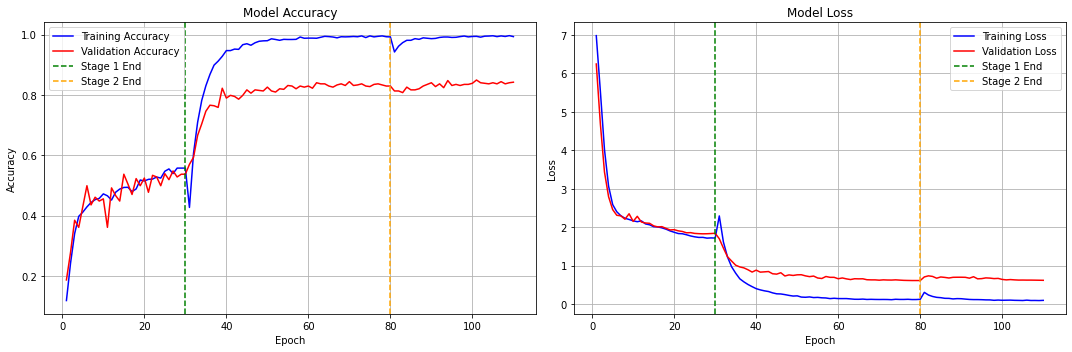


FINAL EVALUATION
Final Validation Accuracy: 84.94%
Final Validation Loss: 0.6296

Best accuracies across stages:
  Stage 1: 54.81%
  Stage 2: 84.39%
  Stage 3: 84.94%


In [4]:
import cv2
import os
import numpy as np
from PIL import Image
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# ==================== Data Loading ====================
path = r'I-Nema'
train_path = glob(path+'\\train\\*\\*.tif')
val_path = glob(path+'\\val_preprocessed\\*\\*.tif')

X_train = []
y_train = []
for image_path in tqdm(train_path):
    im = Image.open(image_path)
    im = im.convert("RGB")
    f = np.array(im)
    if f is None:
        continue
    f = cv2.resize(f, (300,300))
    X_train.append(f)
    y_train.append(image_path.split('\\')[-2])

X_val = []
y_val = []
for image_path in tqdm(val_path):
    im = Image.open(image_path)
    im = im.convert("RGB")
    f = np.array(im)
    if f is None:
        continue
    f = cv2.resize(f, (300,300))
    X_val.append(f)
    y_val.append(image_path.split('\\')[-2])

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


# ==================== Custom Learning Rate Callback ====================
class WarmUpCosineDecayCallback(tf.keras.callbacks.Callback):
    """Learning rate callback with warm-up and cosine decay"""
    def __init__(self, initial_lr, warmup_epochs, total_epochs, steps_per_epoch):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_epochs * steps_per_epoch
        self.total_steps = total_epochs * steps_per_epoch
        self.current_step = 0
        
    def on_train_batch_begin(self, batch, logs=None):
        if self.current_step < self.warmup_steps:
            lr = self.initial_lr * (self.current_step / self.warmup_steps)
        else:
            progress = (self.current_step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
            lr = self.initial_lr * cosine_decay
        
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.current_step += 1


# ==================== Weight Decay Callback ====================
class WeightDecayCallback(tf.keras.callbacks.Callback):
    """Apply weight decay to trainable weights"""
    def __init__(self, weight_decay=1e-4):
        super().__init__()
        self.weight_decay = weight_decay
    
    def on_train_batch_end(self, batch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'kernel') and layer.trainable:
                layer.kernel.assign(layer.kernel * (1 - self.weight_decay))


# ==================== Custom Callback to Track Best Model ====================
class BestModelTracker(tf.keras.callbacks.Callback):
    """Track best validation accuracy without saving to H5"""
    def __init__(self):
        super().__init__()
        self.best_val_acc = 0.0
        self.best_weights = None
        self.best_epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f"\nNew best validation accuracy: {val_acc:.4f} at epoch {self.best_epoch}")
    
    def restore_best_weights(self):
        """Restore the best weights after training"""
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best weights from epoch {self.best_epoch} (val_acc: {self.best_val_acc:.4f})")


# ==================== Build Model ====================
def build_model(num_classes=19):
    """Build EfficientNetB3 model"""
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(300, 300, 3),
        pooling='avg'
    )
    
    x = base_model.output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    
    return model, base_model


# ==================== Data Augmentation ====================
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)


# ==================== STAGE 1: Train with All Base Layers Frozen ====================
print("\n" + "="*60)
print("STAGE 1: Training only the top layers (all base layers frozen)")
print("="*60)

model, base_model = build_model(num_classes=19)

# Freeze ALL base model layers
for layer in base_model.layers:
    layer.trainable = False

print(f"Total layers: {len(model.layers)}")
print(f"Trainable layers: {sum([1 for layer in model.layers if layer.trainable])}")

# Configure parameters
steps_per_epoch = len(X_train) // 16
stage1_epochs = 30
warmup_epochs = 5
initial_lr_stage1 = 1e-3

optimizer_stage1 = tf.keras.optimizers.Adam(learning_rate=initial_lr_stage1)

model.compile(
    optimizer=optimizer_stage1,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks WITHOUT ModelCheckpoint (to avoid serialization error)
best_tracker_stage1 = BestModelTracker()
callbacks_stage1 = [
    WarmUpCosineDecayCallback(
        initial_lr=initial_lr_stage1,
        warmup_epochs=warmup_epochs,
        total_epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch
    ),
    WeightDecayCallback(weight_decay=1e-4),
    best_tracker_stage1,  # Track best model without saving
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=False,  # Restore manually
        verbose=1
    )
]

print("\nTraining Stage 1...")
history_stage1 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    epochs=stage1_epochs,
    callbacks=callbacks_stage1,
    verbose=1
)

# Restore best weights manually
best_tracker_stage1.restore_best_weights()
print(f"\nStage 1 Best Validation Accuracy: {best_tracker_stage1.best_val_acc:.4f}")


# ==================== STAGE 2: Progressive Unfreezing ====================
print("\n" + "="*60)
print("STAGE 2: Progressive unfreezing from top to bottom")
print("="*60)

# Unfreeze the last 80 layers
total_base_layers = len(base_model.layers)
layers_to_unfreeze = 80

for layer in base_model.layers[-layers_to_unfreeze:]:
    layer.trainable = True

print(f"Total base model layers: {total_base_layers}")
print(f"Unfrozen layers: {layers_to_unfreeze}")
print(f"Trainable layers in full model: {sum([1 for layer in model.layers if layer.trainable])}")

stage2_epochs = 50
warmup_epochs_stage2 = 3
initial_lr_stage2 = 1e-4

optimizer_stage2 = tf.keras.optimizers.Adam(learning_rate=initial_lr_stage2)

model.compile(
    optimizer=optimizer_stage2,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_tracker_stage2 = BestModelTracker()
callbacks_stage2 = [
    WarmUpCosineDecayCallback(
        initial_lr=initial_lr_stage2,
        warmup_epochs=warmup_epochs_stage2,
        total_epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch
    ),
    WeightDecayCallback(weight_decay=5e-5),
    best_tracker_stage2,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=False,
        verbose=1
    )
]

print("\nTraining Stage 2...")
history_stage2 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    epochs=stage2_epochs,
    callbacks=callbacks_stage2,
    verbose=1
)

best_tracker_stage2.restore_best_weights()
print(f"\nStage 2 Best Validation Accuracy: {best_tracker_stage2.best_val_acc:.4f}")


# ==================== STAGE 3: Fine-tune with More Layers ====================
print("\n" + "="*60)
print("STAGE 3: Fine-tune with more layers unfrozen")
print("="*60)

# Unfreeze even more layers
for layer in base_model.layers[-120:]:
    layer.trainable = True

print(f"Unfrozen layers: 120")
print(f"Trainable layers in full model: {sum([1 for layer in model.layers if layer.trainable])}")

stage3_epochs = 30
warmup_epochs_stage3 = 2
initial_lr_stage3 = 5e-5

optimizer_stage3 = tf.keras.optimizers.Adam(learning_rate=initial_lr_stage3)

model.compile(
    optimizer=optimizer_stage3,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_tracker_stage3 = BestModelTracker()
callbacks_stage3 = [
    WarmUpCosineDecayCallback(
        initial_lr=initial_lr_stage3,
        warmup_epochs=warmup_epochs_stage3,
        total_epochs=stage3_epochs,
        steps_per_epoch=steps_per_epoch
    ),
    WeightDecayCallback(weight_decay=1e-5),
    best_tracker_stage3,
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=False,
        verbose=1
    )
]

print("\nTraining Stage 3...")
history_stage3 = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val, y_val),
    epochs=stage3_epochs,
    callbacks=callbacks_stage3,
    verbose=1
)

best_tracker_stage3.restore_best_weights()
print(f"\nStage 3 Final Validation Accuracy: {best_tracker_stage3.best_val_acc:.4f}")


# ==================== Safe Model Saving ====================
print("\n" + "="*60)
print("SAVING MODEL SAFELY")
print("="*60)

def safe_save_model(model, base_name):
    """Save model using multiple fallback methods"""
    # Method 1: Try SavedModel format (most reliable)
    try:
        save_path = f'{base_name}_savedmodel'
        model.save(save_path, save_format='tf')
        print(f"Model saved as SavedModel: {save_path}")
        return True
    except Exception as e:
        print(f"SavedModel failed: {e}")
    
    # Method 2: Save weights only
    try:
        weights_path = f'{base_name}_weights.h5'
        model.save_weights(weights_path)
        print(f"Weights saved: {weights_path}")
        return True
    except Exception as e:
        print(f"Weights saving failed: {e}")
    
    return False

# Save the final model
safe_save_model(model, 'nematode_efficientnet_progressive')

# Save training history
import pickle
history_dict = {
    'stage1': history_stage1.history,
    'stage2': history_stage2.history,
    'stage3': history_stage3.history,
    'best_acc_stage1': best_tracker_stage1.best_val_acc,
    'best_acc_stage2': best_tracker_stage2.best_val_acc,
    'best_acc_stage3': best_tracker_stage3.best_val_acc
}

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history_dict, f)
print("Training history saved!")


# ==================== Visualize Training ====================
def plot_training_history(history1, history2, history3):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    all_train_acc = history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy']
    all_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy']
    all_train_loss = history1.history['loss'] + history2.history['loss'] + history3.history['loss']
    all_val_loss = history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']
    
    epochs = range(1, len(all_train_acc) + 1)
    
    # Accuracy
    axes[0].plot(epochs, all_train_acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs, all_val_acc, 'r-', label='Validation Accuracy')
    axes[0].axvline(x=len(history1.history['accuracy']), color='g', linestyle='--', label='Stage 1 End')
    axes[0].axvline(x=len(history1.history['accuracy'])+len(history2.history['accuracy']), 
                   color='orange', linestyle='--', label='Stage 2 End')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(epochs, all_train_loss, 'b-', label='Training Loss')
    axes[1].plot(epochs, all_val_loss, 'r-', label='Validation Loss')
    axes[1].axvline(x=len(history1.history['loss']), color='g', linestyle='--', label='Stage 1 End')
    axes[1].axvline(x=len(history1.history['loss'])+len(history2.history['loss']), 
                   color='orange', linestyle='--', label='Stage 2 End')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

plot_training_history(history_stage1, history_stage2, history_stage3)


# ==================== Final Evaluation ====================
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

final_loss, final_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")
print(f"Final Validation Loss: {final_loss:.4f}")
print(f"\nBest accuracies across stages:")
print(f"  Stage 1: {best_tracker_stage1.best_val_acc*100:.2f}%")
print(f"  Stage 2: {best_tracker_stage2.best_val_acc*100:.2f}%")
print(f"  Stage 3: {best_tracker_stage3.best_val_acc*100:.2f}%")

Loading data...


Loading validation data: 100%|███████████████████████████████████████████████████████| 551/551 [00:07<00:00, 72.06it/s]


Training samples: 2217, Validation samples: 551
Number of classes: 19
Class names: ['Acrobeles' 'Acrobeloides' 'Amplimerlinius' 'Aphelenchoides'
 'Aporcelaimus' 'Axonchium' 'Discolimus' 'Ditylenchus' 'Dorylaimus'
 'Eudorylaimus' 'Helicotylenchus' 'Mesodorylaimus' 'Miconchus'
 'Mylonchulus' 'Panagrolaimus' 'Pratylenchus' 'Pristionchus' 'Rhbiditis'
 'Xenocriconema']

LOADING BEST MODEL


SavedModel loading failed: Unable to create a Keras model from SavedModel at nematode_efficientnet_progressive_savedmodel. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.
H5 loading failed: No file or directory found at best_model_final.h5
Rebuilding model and loading weights...
Model rebuilt and weights loaded

MODEL EVALUATION

Evaluating on Training Set:
70/70 [==============================] - 13s 127ms/step - loss: 0.0599 - accuracy: 1.0000
Training Loss: 0.0599
Training Accuracy: 100.00%

Evaluating on Validation Set:
18/18 [==============================] - 4s 124ms/step - loss: 0.6296 - accuracy: 0.8494
Validation Loss: 0.6296
Validation Accuracy: 84.94%

LOADING TRAINING HISTORY
Training history loaded successfully!

Best Validation Accuracies:
  Stage 1: 54.81%
  Stage 2: 84.3

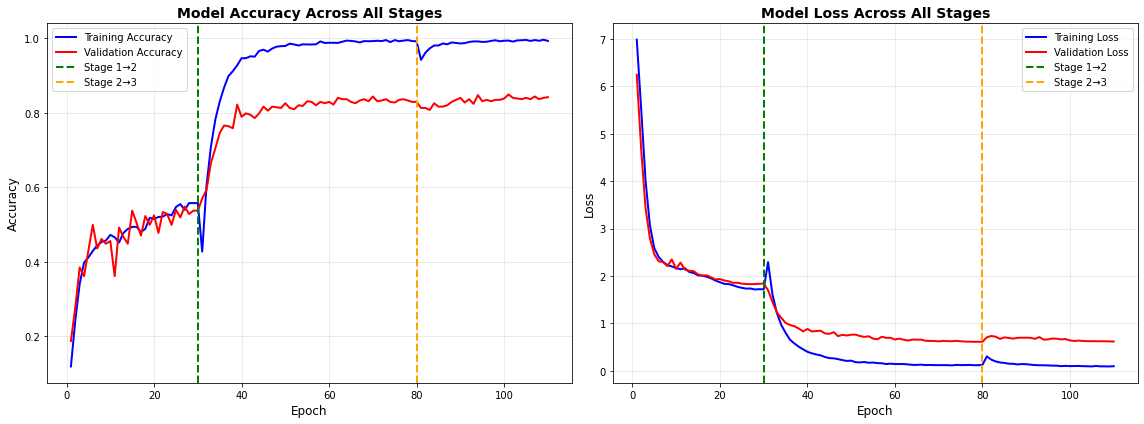


GENERATING PREDICTIONS
Predicting on validation set...
18/18 [==============================] - 4s 142ms/step
Predictions generated for 551 samples

CONFUSION MATRIX
Confusion matrix saved as 'confusion_matrix.png'


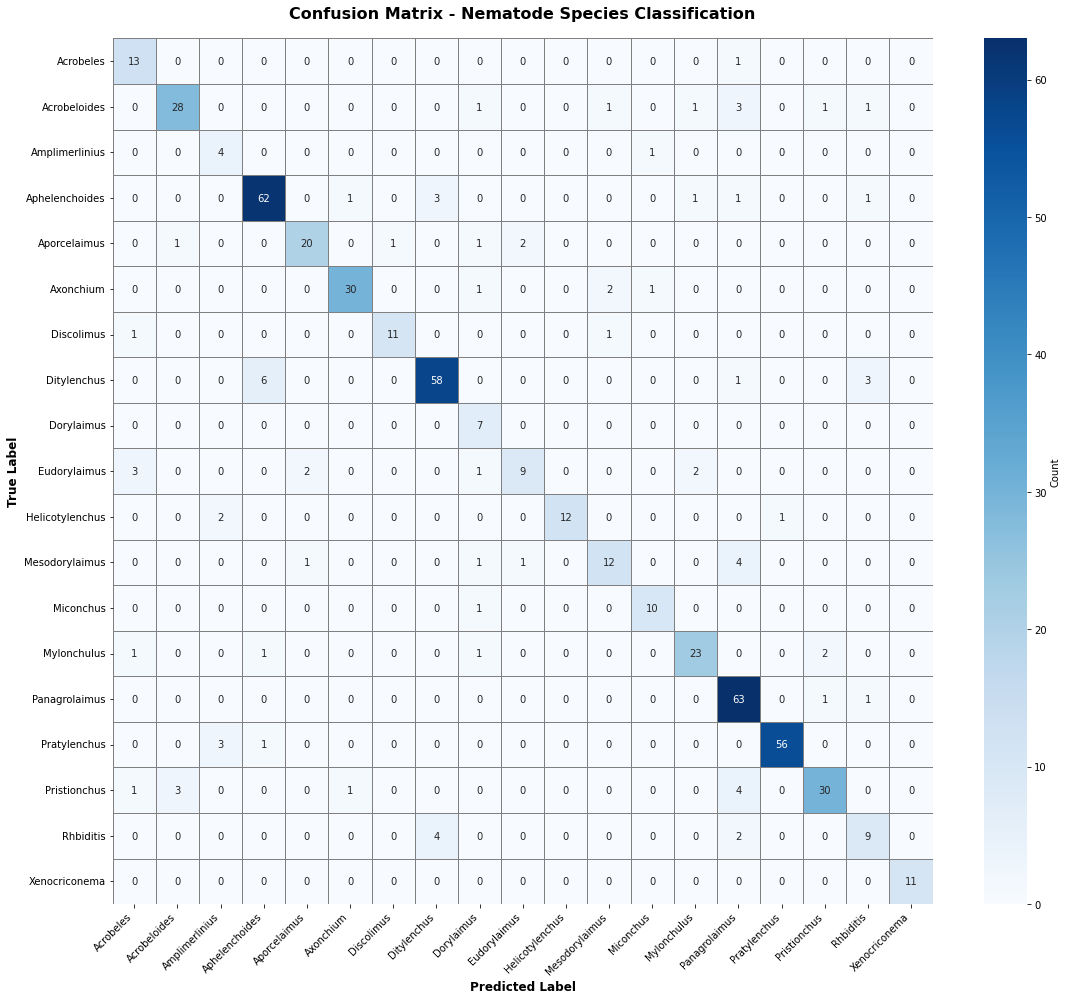


Per-Class Accuracy from Confusion Matrix:
  Acrobeles           :  92.86% ( 13/ 14)
  Acrobeloides        :  77.78% ( 28/ 36)
  Amplimerlinius      :  80.00% (  4/  5)
  Aphelenchoides      :  89.86% ( 62/ 69)
  Aporcelaimus        :  80.00% ( 20/ 25)
  Axonchium           :  88.24% ( 30/ 34)
  Discolimus          :  84.62% ( 11/ 13)
  Ditylenchus         :  85.29% ( 58/ 68)
  Dorylaimus          : 100.00% (  7/  7)
  Eudorylaimus        :  52.94% (  9/ 17)
  Helicotylenchus     :  80.00% ( 12/ 15)
  Mesodorylaimus      :  63.16% ( 12/ 19)
  Miconchus           :  90.91% ( 10/ 11)
  Mylonchulus         :  82.14% ( 23/ 28)
  Panagrolaimus       :  96.92% ( 63/ 65)
  Pratylenchus        :  93.33% ( 56/ 60)
  Pristionchus        :  76.92% ( 30/ 39)
  Rhbiditis           :  60.00% (  9/ 15)
  Xenocriconema       : 100.00% ( 11/ 11)

CLASSIFICATION REPORT

                 precision    recall  f1-score   support

      Acrobeles     0.6842    0.9286    0.7879        14
   Acrobeloides     

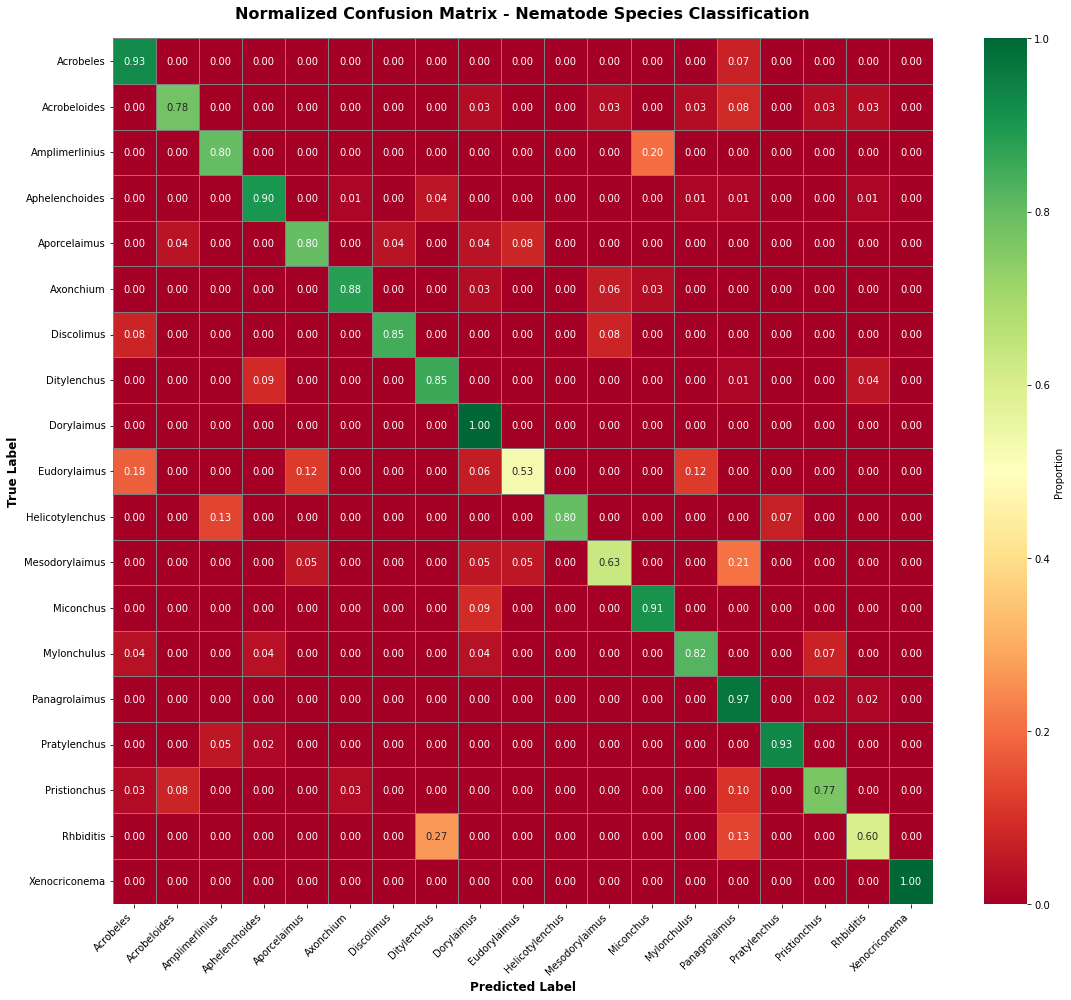


ADDITIONAL VISUALIZATIONS
Metrics visualization saved as 'metrics_by_species.png'


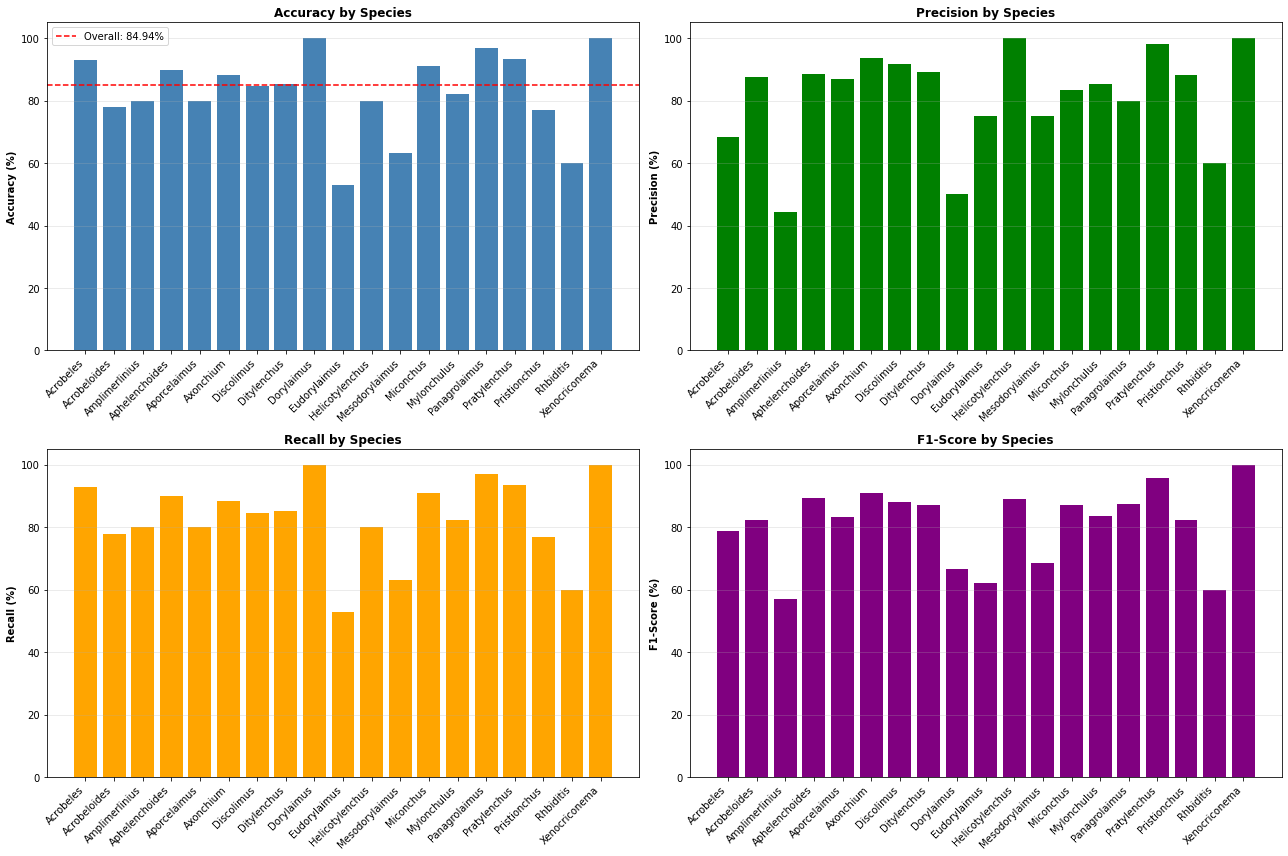


FINAL SUMMARY

Model Performance Summary:
  Training Accuracy:   100.00%
  Validation Accuracy: 84.94%
  Training Loss:       0.0599
  Validation Loss:     0.6296

Best Class Performance:
  Best: Dorylaimus (100.00%)
  Worst: Eudorylaimus (52.94%)

All results saved successfully!
  - complete_training_history.png
  - confusion_matrix.png
  - confusion_matrix_normalized.png
  - classification_report.txt
  - metrics_by_species.png


In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from glob import glob
from tqdm import tqdm
from PIL import Image
import cv2

# ==================== Load Data (Same as training) ====================
print("Loading data...")
path = r'C:\Users\black\Desktop\I-Nema classification\I-Nema'
train_path = glob(path+'\\train\\*\\*.tif')
val_path = glob(path+'\\val_preprocessed\\*\\*.tif')

X_train = []
y_train = []
for image_path in tqdm(train_path, desc="Loading training data"):
    im = Image.open(image_path)
    im = im.convert("RGB")
    f = np.array(im)
    if f is None:
        continue
    f = cv2.resize(f, (300,300))
    X_train.append(f)
    y_train.append(image_path.split('\\')[-2])

X_val = []
y_val = []
for image_path in tqdm(val_path, desc="Loading validation data"):
    im = Image.open(image_path)
    im = im.convert("RGB")
    f = np.array(im)
    if f is None:
        continue
    f = cv2.resize(f, (300,300))
    X_val.append(f)
    y_val.append(image_path.split('\\')[-2])

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
print(f"Number of classes: {len(encoder.classes_)}")
print(f"Class names: {encoder.classes_}")


# ==================== Load Best Model ====================
print("\n" + "="*60)
print("LOADING BEST MODEL")
print("="*60)

def load_best_model():
    """Try to load model from different saved formats"""
    try:
        model = tf.keras.models.load_model('nematode_efficientnet_progressive_savedmodel')
        print("Model loaded from SavedModel format")
        return model
    except Exception as e:
        print(f"SavedModel loading failed: {e}")
    
    try:
        model = tf.keras.models.load_model('best_model_final.h5')
        print("Model loaded from best_model_final.h5")
        return model
    except Exception as e:
        print(f"H5 loading failed: {e}")
    
    try:
        print("Rebuilding model and loading weights...")
        from tensorflow.keras.applications import EfficientNetB3
        
        base_model = EfficientNetB3(
            include_top=False,
            weights='imagenet',
            input_shape=(300, 300, 3),
            pooling='avg'
        )
        
        x = base_model.output
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(256, activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output = tf.keras.layers.Dense(19, activation='softmax')(x)
        
        model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
        model.load_weights('nematode_efficientnet_progressive_weights.h5')
        print("Model rebuilt and weights loaded")
        return model
    except Exception as e:
        print(f"Weight loading failed: {e}")
    
    print("All loading methods failed!")
    return None

model = load_best_model()

if model is None:
    print("ERROR: Could not load model. Please check saved files.")
    exit()


# ==================== Evaluate Model ====================
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nEvaluating on Training Set:")
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

print("\nEvaluating on Validation Set:")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


# ==================== Load and Display Training History ====================
print("\n" + "="*60)
print("LOADING TRAINING HISTORY")
print("="*60)

try:
    with open('training_history.pkl', 'rb') as f:
        history_dict = pickle.load(f)
    
    print("Training history loaded successfully!")
    
    print("\nBest Validation Accuracies:")
    if 'best_acc_stage1' in history_dict:
        print(f"  Stage 1: {history_dict['best_acc_stage1']*100:.2f}%")
    if 'best_acc_stage2' in history_dict:
        print(f"  Stage 2: {history_dict['best_acc_stage2']*100:.2f}%")
    if 'best_acc_stage3' in history_dict:
        print(f"  Stage 3: {history_dict['best_acc_stage3']*100:.2f}%")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    all_train_acc = (history_dict['stage1']['accuracy'] + 
                     history_dict['stage2']['accuracy'] + 
                     history_dict['stage3']['accuracy'])
    all_val_acc = (history_dict['stage1']['val_accuracy'] + 
                   history_dict['stage2']['val_accuracy'] + 
                   history_dict['stage3']['val_accuracy'])
    all_train_loss = (history_dict['stage1']['loss'] + 
                      history_dict['stage2']['loss'] + 
                      history_dict['stage3']['loss'])
    all_val_loss = (history_dict['stage1']['val_loss'] + 
                    history_dict['stage2']['val_loss'] + 
                    history_dict['stage3']['val_loss'])
    
    epochs = range(1, len(all_train_acc) + 1)
    stage1_end = len(history_dict['stage1']['accuracy'])
    stage2_end = stage1_end + len(history_dict['stage2']['accuracy'])
    
    axes[0].plot(epochs, all_train_acc, 'b-', linewidth=2, label='Training Accuracy')
    axes[0].plot(epochs, all_val_acc, 'r-', linewidth=2, label='Validation Accuracy')
    axes[0].axvline(x=stage1_end, color='g', linestyle='--', linewidth=2, label='Stage 1→2')
    axes[0].axvline(x=stage2_end, color='orange', linestyle='--', linewidth=2, label='Stage 2→3')
    axes[0].set_title('Model Accuracy Across All Stages', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, all_train_loss, 'b-', linewidth=2, label='Training Loss')
    axes[1].plot(epochs, all_val_loss, 'r-', linewidth=2, label='Validation Loss')
    axes[1].axvline(x=stage1_end, color='g', linestyle='--', linewidth=2, label='Stage 1→2')
    axes[1].axvline(x=stage2_end, color='orange', linestyle='--', linewidth=2, label='Stage 2→3')
    axes[1].set_title('Model Loss Across All Stages', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('complete_training_history.png', dpi=300, bbox_inches='tight')
    print("\nTraining history plot saved as 'complete_training_history.png'")
    plt.show()
    
except Exception as e:
    print(f"Error loading training history: {e}")


# ==================== Generate Predictions ====================
print("\n" + "="*60)
print("GENERATING PREDICTIONS")
print("="*60)

print("Predicting on validation set...")
y_pred_probs = model.predict(X_val, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Predictions generated for {len(y_pred)} samples")


# ==================== Confusion Matrix ====================
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix - Nematode Species Classification', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

print("\nPer-Class Accuracy from Confusion Matrix:")
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(encoder.classes_, class_accuracies)):
    print(f"  {class_name:20s}: {acc*100:6.2f}% ({cm[i,i]:3d}/{cm[i].sum():3d})")


# ==================== Classification Report ====================
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)

report = classification_report(y_val, y_pred, 
                               target_names=encoder.classes_, 
                               digits=4)
print("\n" + report)

with open('classification_report.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("NEMATODE SPECIES CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n\n")
    f.write(f"Overall Validation Accuracy: {val_accuracy*100:.2f}%\n")
    f.write(f"Overall Validation Loss: {val_loss:.4f}\n\n")
    f.write(report)
    f.write("\n\nPer-Class Details:\n")
    f.write("-"*60 + "\n")
    for i, class_name in enumerate(encoder.classes_):
        total = cm[i].sum()
        correct = cm[i, i]
        accuracy = class_accuracies[i]
        f.write(f"{class_name:20s}: {correct:3d}/{total:3d} correct ({accuracy*100:6.2f}%)\n")

print("Classification report saved as 'classification_report.txt'")


# ==================== Normalized Confusion Matrix ====================
print("\n" + "="*60)
print("NORMALIZED CONFUSION MATRIX")
print("="*60)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_,
            cbar_kws={'label': 'Proportion'},
            vmin=0, vmax=1,
            linewidths=0.5, linecolor='gray')
plt.title('Normalized Confusion Matrix - Nematode Species Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print("Normalized confusion matrix saved as 'confusion_matrix_normalized.png'")
plt.show()


# ==================== Additional Metrics Visualization ====================
print("\n" + "="*60)
print("ADDITIONAL VISUALIZATIONS")
print("="*60)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_val, y_pred, labels=range(len(encoder.classes_))
)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0, 0].bar(range(len(encoder.classes_)), class_accuracies*100, color='steelblue')
axes[0, 0].set_xticks(range(len(encoder.classes_)))
axes[0, 0].set_xticklabels(encoder.classes_, rotation=45, ha='right')
axes[0, 0].set_ylabel('Accuracy (%)', fontweight='bold')
axes[0, 0].set_title('Accuracy by Species', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=val_accuracy*100, color='r', linestyle='--', label=f'Overall: {val_accuracy*100:.2f}%')
axes[0, 0].legend()

axes[0, 1].bar(range(len(encoder.classes_)), precision*100, color='green')
axes[0, 1].set_xticks(range(len(encoder.classes_)))
axes[0, 1].set_xticklabels(encoder.classes_, rotation=45, ha='right')
axes[0, 1].set_ylabel('Precision (%)', fontweight='bold')
axes[0, 1].set_title('Precision by Species', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

axes[1, 0].bar(range(len(encoder.classes_)), recall*100, color='orange')
axes[1, 0].set_xticks(range(len(encoder.classes_)))
axes[1, 0].set_xticklabels(encoder.classes_, rotation=45, ha='right')
axes[1, 0].set_ylabel('Recall (%)', fontweight='bold')
axes[1, 0].set_title('Recall by Species', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

axes[1, 1].bar(range(len(encoder.classes_)), f1*100, color='purple')
axes[1, 1].set_xticks(range(len(encoder.classes_)))
axes[1, 1].set_xticklabels(encoder.classes_, rotation=45, ha='right')
axes[1, 1].set_ylabel('F1-Score (%)', fontweight='bold')
axes[1, 1].set_title('F1-Score by Species', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_by_species.png', dpi=300, bbox_inches='tight')
print("Metrics visualization saved as 'metrics_by_species.png'")
plt.show()


# ==================== Summary ====================
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nModel Performance Summary:")
print(f"  Training Accuracy:   {train_accuracy*100:.2f}%")
print(f"  Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"  Training Loss:       {train_loss:.4f}")
print(f"  Validation Loss:     {val_loss:.4f}")
print(f"\nBest Class Performance:")
best_class_idx = np.argmax(class_accuracies)
print(f"  Best: {encoder.classes_[best_class_idx]} ({class_accuracies[best_class_idx]*100:.2f}%)")
worst_class_idx = np.argmin(class_accuracies)
print(f"  Worst: {encoder.classes_[worst_class_idx]} ({class_accuracies[worst_class_idx]*100:.2f}%)")
print(f"\nAll results saved successfully!")
print(f"  - complete_training_history.png")
print(f"  - confusion_matrix.png")
print(f"  - confusion_matrix_normalized.png")
print(f"  - classification_report.txt")
print(f"  - metrics_by_species.png")
